In [17]:
%matplotlib notebook

import sys
import os
import numpy as np
import cv2
sys.path.append("./utils/") # Adds higher directory to python modules path.
import loadcoraldata_utils as coralutils
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from NeMO_losses import charbonnierLoss
import NeMO_layers
from keras.models import Model, Sequential, load_model
from scipy.misc import imresize
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from metrics import metrics
import json

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

%matplotlib notebook

model = load_model('./tmp/RefineMask_Jarrett256_RGB_NIR3.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [53]:
img = coralutils.CoralData("/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_336801/20181216_214344_0f35/20181216_214344_0f35_3B_AnalyticMS_SR.tif", load_type="raster")
jsonpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_336801/20181216_214344_0f35/20181216_214344_0f35_metadata.json"
with open(jsonpath) as json_file:
    json_data = json.load(json_file)
    

(3823, 8941, 4)
6314.0
{'_links': {'_self': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20181216_214344_0f35', 'assets': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20181216_214344_0f35/assets/', 'thumbnail': 'https://tiles.planet.com/data/v1/item-types/PSScene4Band/items/20181216_214344_0f35/thumb'}, '_permissions': ['assets.basic_analytic_rpc_nitf:download', 'assets.udm2:download', 'assets.analytic_xml:download', 'assets.basic_analytic_dn:download', 'assets.basic_analytic_dn_xml_nitf:download', 'assets.basic_analytic_dn_nitf:download', 'assets.basic_analytic_xml:download', 'assets.basic_analytic_nitf:download', 'assets.basic_analytic_rpc:download', 'assets.analytic_dn:download', 'assets.basic_udm:download', 'assets.basic_analytic_dn_rpc_nitf:download', 'assets.analytic:download', 'assets.analytic_dn_xml:download', 'assets.analytic_sr:download', 'assets.basic_analytic_dn_xml:download', 'assets.basic_udm2:download', 'assets.basic_analytic_dn_rpc:down

<IPython.core.display.Javascript object>


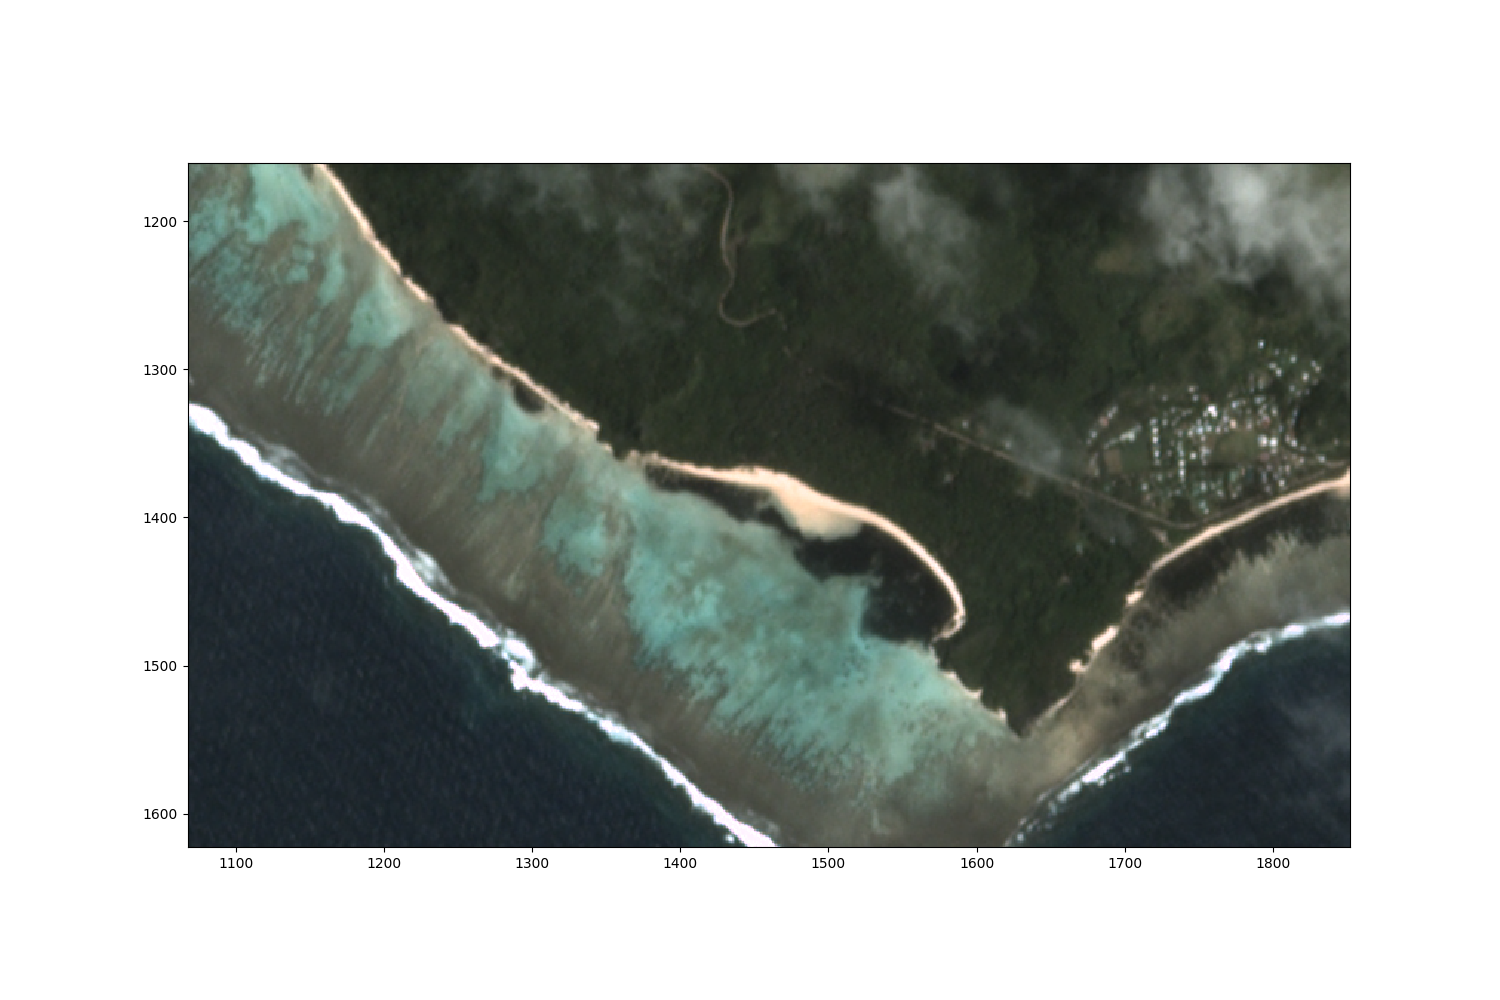

In [54]:
print(img.image.shape)
img.truthimage = np.zeros(img.image.shape)
print(np.max(img.image))
print(json_data)

def fixRGBimg(img,pixel_mean,pixel_std,minval,maxval):
    fixed_img = np.copy(img)
    if type(pixel_std) == list:
        for i,std in enumerate(pixel_std):
            fixed_img[:,:,i] = fixed_img[:,:,i]*std+pixel_mean
    else:
        fixed_img = fixed_img*pixel_std+pixel_mean
    fixed_img[fixed_img > maxval] = maxval
    fixed_img[fixed_img < minval] = minval
    fixed_img = np.asarray(fixed_img, dtype=np.uint8)
    return fixed_img

fixed_img = fixRGBimg(img.image,0,255/3000,0,255) # turn into 0-255

fig = plt.figure(1, figsize=(15,10))
pic = np.rollaxis(np.asarray([fixed_img[:,:,2], fixed_img[:,:,1], fixed_img[:,:,0]]),0,3)
pic = np.asarray(pic, dtype=np.uint8)
plt.imshow(pic)
plt.show()


<IPython.core.display.Javascript object>


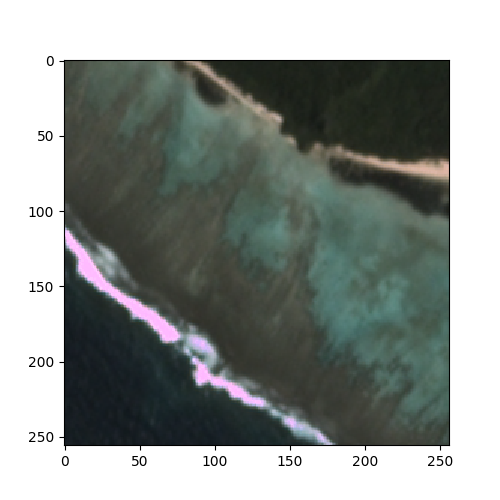

[255 190 255]


In [60]:
cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)


xstart = 1200
xlen = 256
ystart = 1300
ylen = 256

test_img = fixRGBimg(img.image,0,[255/4000,255/4000,255/4000,255/4000],0,255) # turn into 0-255
predict_size = 256
img.testimage = test_img[ystart:ystart+ylen,xstart:xstart+xlen,:]

fig = plt.figure(2, figsize=(5,5))
pic = np.rollaxis(np.asarray([img.testimage[:,:,2], img.testimage[:,:,1], img.testimage[:,:,0]]),0,3)
pic = np.asarray(pic, dtype=np.uint8)
plt.imshow(pic)
plt.show()

print(pic[150,25])

In [61]:
jsonclasspath = './utils/CoralClasses.json'

with open(jsonclasspath) as json_file:
    json_classes = json.load(json_file)

labelkey = json_classes["VedConsolidated_ClassDict"]
class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v
print(class_indices_rev)

img.set_mean_std(100,100)
whole_predict, num_predict, prob_predict, truth_predict, accuracy = \
    img.predict_on_whole_image(model, image_size = 256, num_classes = len(class_indices_rev), spacing = (256,256), predict_size = 256, num_lines=None, lastchannelremove=False)



{1: 'Coral', 2: 'Sediment', 3: 'Beach', 4: 'Seagrass', 5: 'Terrestrial vegetation', 6: 'Deep water', 7: 'Clouds', 8: 'Wave breaking', 9: 'Other or Unknown'}
Line: 0 Col: 0/ 1 completed


<IPython.core.display.Javascript object>


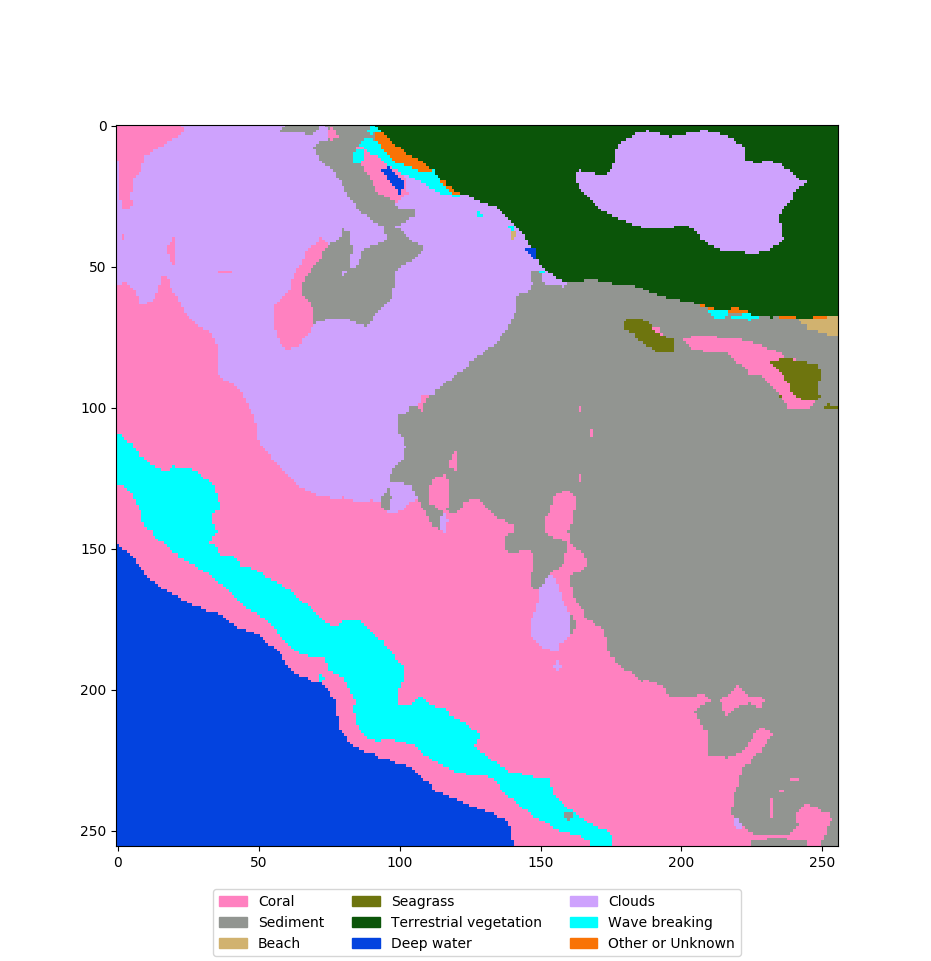

In [62]:
fig = plt.figure(3,figsize=(8,8))
plt.imshow(whole_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
plt.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
plt.show()

